# THE PURPOSE OF THIS PYTHON NOTEBOOK
1. Compute nog metrics, group my correlations stuff volgens model ipv distillation type
2. Further investigation of laten variable
    1. Vir gegewe model
    2. Kry die samples se featuremap(s) (en attentionmaps) en groepeer volgens
        - 99% confidence correct
        - 99% confidence incorrect
        - 1% confidence correct
        - 1% confidence incorrect
    3. Compute die ENTROPY vir elke een
    4. Herhaal vir ander models
        - Kyk wat die overlap is tussen die verskillende models (en verskillende iterations van dieselfde model)
3. Kan ek nog iets doen met die transform visualization en noise calculation?

In [2]:
from toolbox.models import ResNet112, ResNet56, ResNet20, ResNetBaby
from toolbox.factor_transfer_components import Paraphraser, Translator

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from rich import print as pprint
import os
import glob

device = 'cuda'
plt.rcParams['image.cmap'] = 'magma'

In [ ]:
mean, std = (0.5071, 0.4867, 0.4409), (0.267, 0.256, 0.276) 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
testset = torchvision.datasets.CIFAR100(root='../data', train=False, download=True, transform=transform_test)
batch_size = len(testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

MODELS = {
    'ResNet112': ResNet112,
    'ResNet56': ResNet56,
    'ResNet20': ResNet20,
    'ResNetBaby': ResNetBaby
}

all_models = {}

root_dir = "../experiments-24-03"
pth_files = glob.glob(os.path.join(root_dir, "**/Cifar100_ResNet*.pth"), recursive=True)

for file_path in pth_files:
    split = file_path.split('\\')[1:]
    run_number, distillation_type = (split[2], 'None') if split[2].isdigit() else (split[3], split[2])
    model_name = split[1].split('_')[0] 
    if model_name == 'ResNetBaby' and distillation_type == 'None' and run_number == '1':
        model = MODELS[model_name](100).to(device)
        checkpoint = torch.load(file_path, weights_only=True)
        model.load_state_dict(checkpoint['weights'])
        all_models[f'{model_name}_{distillation_type}'] = model
        print(f'Loaded: {model_name}-{distillation_type}')


Files already downloaded and verified
Loaded: ResNet112-None
Loaded: ResNet20-None
Loaded: ResNet20-ft
Loaded: ResNet20-kd
Loaded: ResNet20-td
Loaded: ResNet56-None
Loaded: ResNet56-ft
Loaded: ResNet56-kd
Loaded: ResNet56-td
Loaded: ResNetBaby-None
Loaded: ResNetBaby-ft
Loaded: ResNetBaby-kd
Loaded: ResNetBaby-td


In [ ]:
def get_batch(Model):
    Model.eval()

    with torch.no_grad():
        outputs = Model(inputs)
    probs = torch.nn.functional.softmax(outputs[3], dim=1)
    confidence, predicted = torch.max(probs.data, 1)

    return [{
        'feature_map': [outputs[idx][i] for idx in range(3)],
        'correct': predicted.eq(targets.data).cpu().float()[i].item() == 1.0,
        'predicted_class': np.array(testloader.dataset.classes)[predicted.data.cpu()][i],
        'correct_class': np.array(testloader.dataset.classes)[targets.data.cpu()][i],
        'confidence': confidence[i].item()
    } for i in range(batch_size)]

inputs, targets = next(iter(testloader)) 
inputs, targets = inputs.to(device), targets.to(device)

batch = {}
for model in ['ResNet112', 'ResNet56', 'ResNet20', 'ResNetBaby']:
    for dist_type in ['None', 'kd', 'ft', 'td']:
        key = f'{model}_{dist_type}'
        if key in all_models:
            batch[key] = get_batch(all_models[key]) 
            print(f'Added {model}-{dist_type} to active batch')

Added ResNet112-None to active batch
Added ResNet56-None to active batch
Added ResNet56-kd to active batch
Added ResNet56-ft to active batch
Added ResNet56-td to active batch
Added ResNet20-None to active batch
Added ResNet20-kd to active batch
Added ResNet20-ft to active batch
Added ResNet20-td to active batch
Added ResNetBaby-None to active batch
Added ResNetBaby-kd to active batch
Added ResNetBaby-ft to active batch
Added ResNetBaby-td to active batch


In [33]:
def compute_cv(feature_map):
    mean = torch.mean(feature_map)
    std = torch.std(feature_map)
    cv = mean / (std.abs() + 1e-10)
    return cv.item()
def compute_entropy(feature_map): 
    feature_map = feature_map - feature_map.min()  
    sum_fm = feature_map.sum()
    if sum_fm == 0:  # Avoid division by zero
        return torch.tensor(0.0, device=feature_map.device)
    probs = feature_map / sum_fm
    entropy = -torch.sum(probs * torch.log(probs + 1e-10))
    return entropy.item()

from tqdm import trange
for model in ['ResNet112', 'ResNet56', 'ResNet20', 'ResNetBaby']:
    for dist_type in ['None', 'kd', 'ft', 'td']:
        key = f'{model}_{dist_type}'
        key = 'ResNet56_None'
        print(f'Computing metrics for {key}')
        if key in all_models:
            for i in trange(batch_size):
                batch[key][i]['entropy'] = [0,0,compute_entropy(batch[key][i]['feature_map'][2])]
                batch[key][i]['cv'] = [0,0,compute_cv(batch[key][i]['feature_map'][2])]

        break
    break
print("Done")

Computing metrics for ResNet56_None


100%|██████████| 10000/10000 [00:15<00:00, 632.48it/s]

Done


In [34]:
print(batch['ResNet56_None'][0]['entropy'])

[0, 0, 7.3137407302856445]


Doing things for entropy
Pearson Correlation Coefficient for entropy - correct: -0.397
Pearson Correlation Coefficient for entropy - incorrect: -0.373


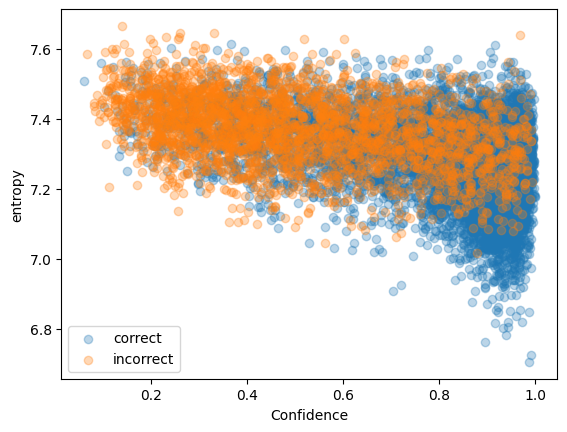

Doing things for cv
Pearson Correlation Coefficient for cv - correct: -0.406
Pearson Correlation Coefficient for cv - incorrect: -0.380


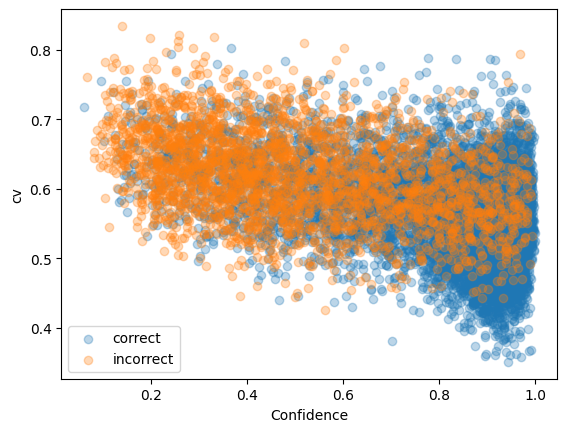

Pearson Correlation Coefficient for correct: 0.955
Pearson Correlation Coefficient for incorrect: 0.966


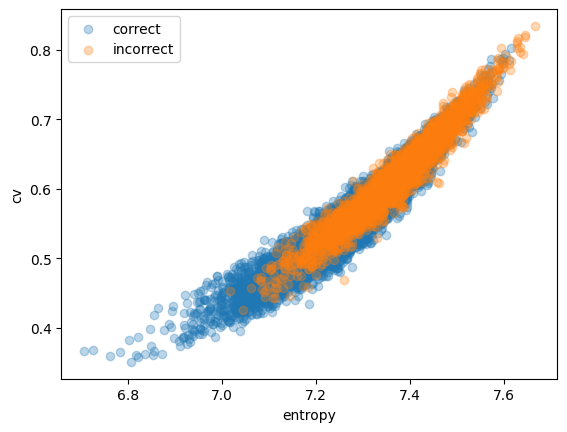

In [35]:
for key in ["ResNet56_None"]:
    confs, entrops, cvs = [[],[]], [[],[]], [[],[]]
    for i in range(batch_size):
        current = batch[key][i]
        index = 0 if current['correct'] else 1 
        confs[index].append(current['confidence'])
        entrops[index].append(current['entropy'][2])
        cvs[index].append(current['cv'][2])

    things = ["entropy", "cv"]
    for i, thing in enumerate([entrops, cvs]):
        print(f"Doing things for {things[i]}")
        for num in [0,1]:
            pred = 'correct' if num == 0 else 'incorrect'
            plt.scatter(confs[num], thing[num], alpha=0.3, label=pred)
            correlation = np.corrcoef(confs[num], thing[num])[0, 1]
            print(f"Pearson Correlation Coefficient for {things[i]} - {pred}: {correlation:.3f}")
        plt.xlabel('Confidence')
        plt.ylabel(things[i])
        plt.legend()
        plt.show()

    
    for num in [0,1]:
        pred = 'correct' if num == 0 else 'incorrect'
        plt.scatter(entrops[num], cvs[num], alpha=0.3, label=pred)
        correlation = np.corrcoef(entrops[num], cvs[num])[0, 1]
        print(f"Pearson Correlation Coefficient for {pred}: {correlation:.3f}")
    
    plt.xlabel('entropy')
    plt.ylabel('cv')
    plt.legend()
    plt.show()

    break

# SOME STUFF BELOW

Pearson Correlation Coefficient correct: -0.001
Pearson Correlation Coefficient incorrect: 0.002


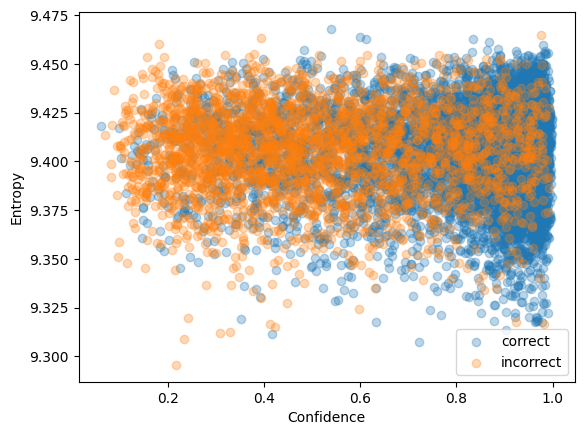

Pearson Correlation Coefficient correct: -0.037
Pearson Correlation Coefficient incorrect: 0.030


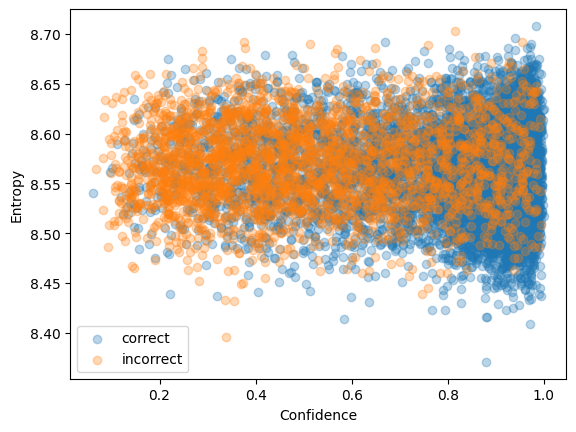

Pearson Correlation Coefficient correct: -0.397
Pearson Correlation Coefficient incorrect: -0.373


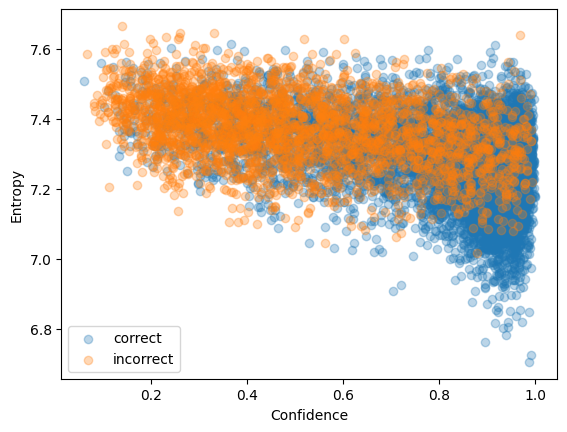

In [ ]:
for entrops in [entrops0, entrops1, entrops2]:
    for num in [0,1]:
        pred = 'correct' if num == 0 else 'incorrect'
        plt.scatter(confs[num], entrops[num], alpha=0.3, label=pred)
        correlation = np.corrcoef(confs[num], entrops[num])[0, 1]
        print(f"Pearson Correlation Coefficient {pred}: {correlation:.3f}")
    plt.xlabel('Confidence')
    plt.ylabel('Entropy')
    plt.legend()
    plt.show()


        #  model_name == 'ResNet112'  distillation_type == 'None' 


Pearson Correlation Coefficient correct: 0.014
Pearson Correlation Coefficient incorrect: -0.001


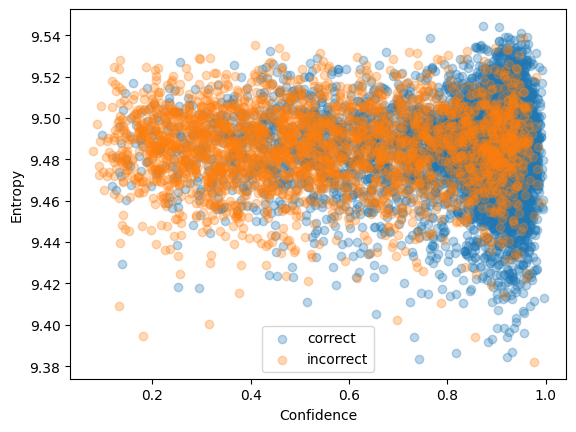

Pearson Correlation Coefficient correct: -0.016
Pearson Correlation Coefficient incorrect: 0.040


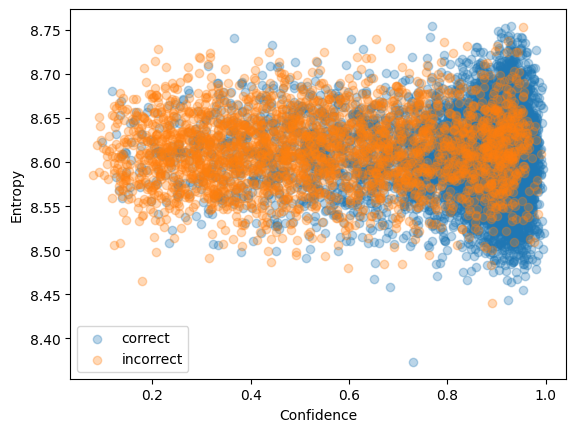

Pearson Correlation Coefficient correct: -0.451
Pearson Correlation Coefficient incorrect: -0.483


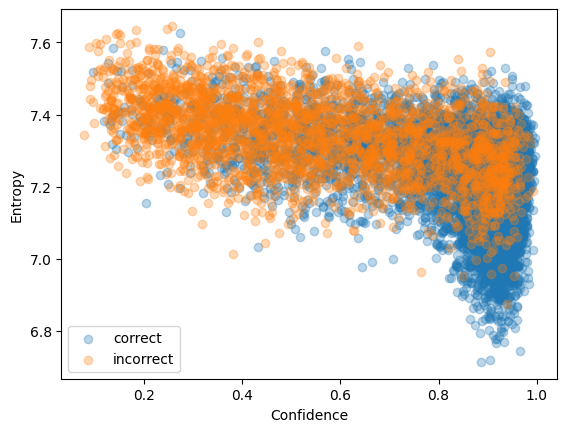

In [ ]:
for entrops in [entrops0, entrops1, entrops2]:
    for num in [0,1]:
        pred = 'correct' if num == 0 else 'incorrect'
        plt.scatter(confs[num], entrops[num], alpha=0.3, label=pred)
        correlation = np.corrcoef(confs[num], entrops[num])[0, 1]
        print(f"Pearson Correlation Coefficient {pred}: {correlation:.3f}")
    plt.xlabel('Confidence')
    plt.ylabel('Entropy')
    plt.legend()
    plt.show()


        #  model_name == 'ResNet56'  distillation_type == 'None' 


Pearson Correlation Coefficient correct: 0.008
Pearson Correlation Coefficient incorrect: 0.035


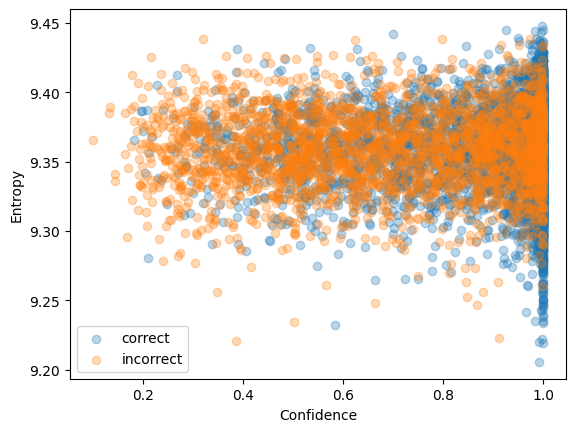

Pearson Correlation Coefficient correct: -0.048
Pearson Correlation Coefficient incorrect: 0.058


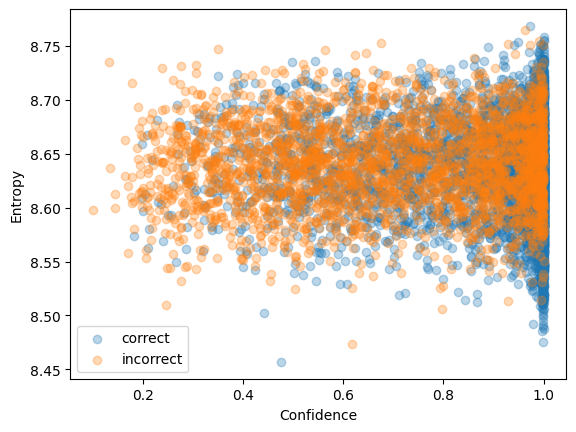

Pearson Correlation Coefficient correct: -0.395
Pearson Correlation Coefficient incorrect: -0.409


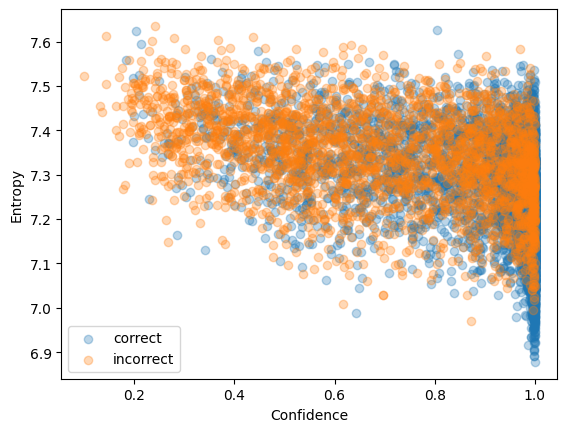

In [ ]:
for entrops in [entrops0, entrops1, entrops2]:
    for num in [0,1]:
        pred = 'correct' if num == 0 else 'incorrect'
        plt.scatter(confs[num], entrops[num], alpha=0.3, label=pred)
        correlation = np.corrcoef(confs[num], entrops[num])[0, 1]
        print(f"Pearson Correlation Coefficient {pred}: {correlation:.3f}")
    plt.xlabel('Confidence')
    plt.ylabel('Entropy')
    plt.legend()
    plt.show()


        #  model_name == 'ResNet56'  distillation_type == 'ft' 


Pearson Correlation Coefficient correct: -0.005
Pearson Correlation Coefficient incorrect: -0.056


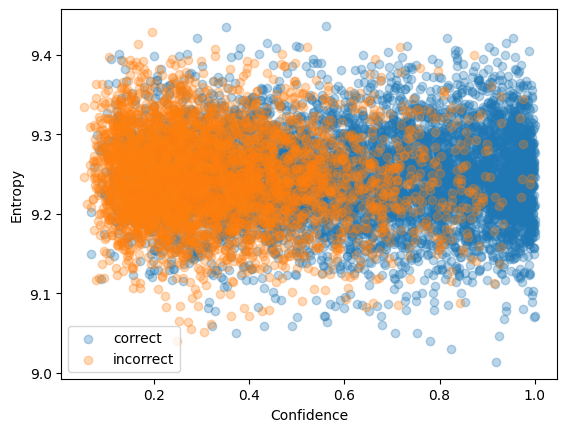

Pearson Correlation Coefficient correct: -0.122
Pearson Correlation Coefficient incorrect: -0.105


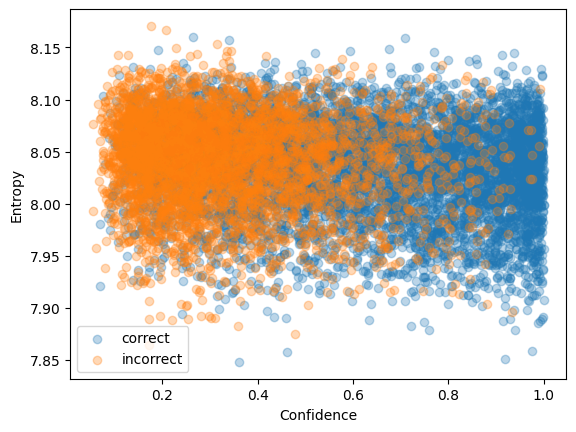

Pearson Correlation Coefficient correct: -0.264
Pearson Correlation Coefficient incorrect: -0.261


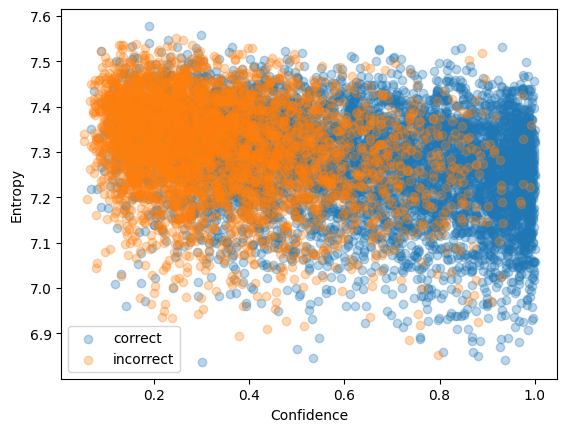

In [57]:
for entrops in [entrops0, entrops1, entrops2]:
    for num in [0,1]:
        pred = 'correct' if num == 0 else 'incorrect'
        plt.scatter(confs[num], entrops[num], alpha=0.3, label=pred)
        correlation = np.corrcoef(confs[num], entrops[num])[0, 1]
        print(f"Pearson Correlation Coefficient {pred}: {correlation:.3f}")
    plt.xlabel('Confidence')
    plt.ylabel('Entropy')
    plt.legend()
    plt.show()

# THIS IS RESNET BABY NONE 

Pearson Correlation Coefficient correct: -0.103
Pearson Correlation Coefficient incorrect: -0.141


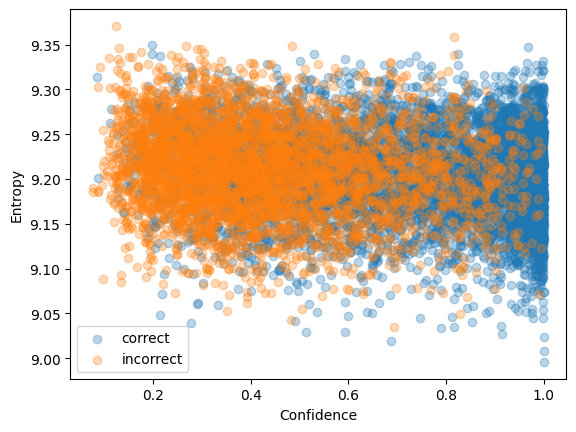

Pearson Correlation Coefficient correct: -0.191
Pearson Correlation Coefficient incorrect: -0.161


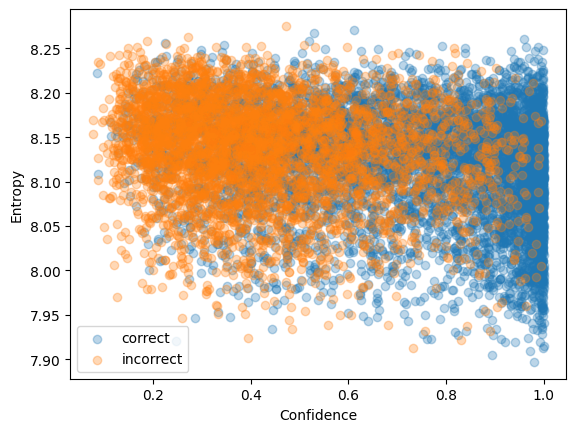

Pearson Correlation Coefficient correct: -0.202
Pearson Correlation Coefficient incorrect: -0.204


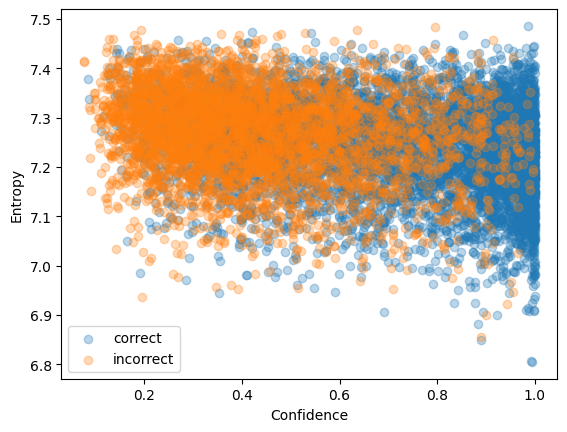

In [ ]:
for entrops in [entrops0, entrops1, entrops2]:
    for num in [0,1]:
        pred = 'correct' if num == 0 else 'incorrect'
        plt.scatter(confs[num], entrops[num], alpha=0.3, label=pred)
        correlation = np.corrcoef(confs[num], entrops[num])[0, 1]
        print(f"Pearson Correlation Coefficient {pred}: {correlation:.3f}")
    plt.xlabel('Confidence')
    plt.ylabel('Entropy')
    plt.legend()
    plt.show()

# THIS IS RESNET BABY FT